In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as im
import matplotlib.colors as colors
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
def thresholding(channel, min=0, max=255):
    binary = np.zeros_like(channel).astype(np.uint8)
    binary[(channel > min) & (channel <= max)] = 1
    return binary

def filter_image(image):
    hsv_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    sensitivity = 51
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    lower_yellow = np.array([18,102,204], np.uint8)
    upper_yellow = np.array([25,255,255], np.uint8)
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    filtered_image = cv2.bitwise_and(image, image, mask=white_mask+yellow_mask)
    return filtered_image

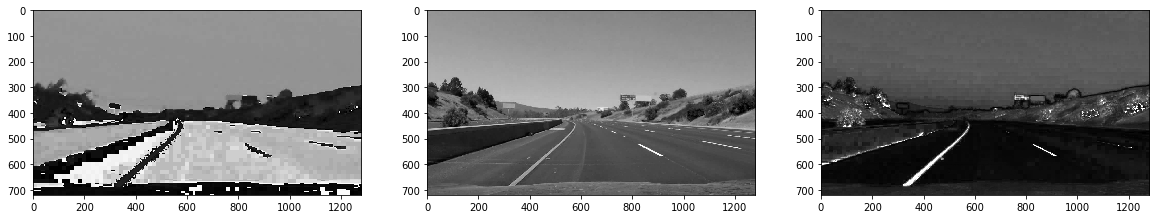

In [3]:
image = im.imread('./frames/frame-0001.jpg')
HLS   = cv2.cvtColor(image, cv2.COLOR_RGB2HLS_FULL)
H,L,S = cv2.split(HLS)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H, cmap='gray')
ax2.imshow(L, cmap='gray')
ax3.imshow(S, cmap='gray')


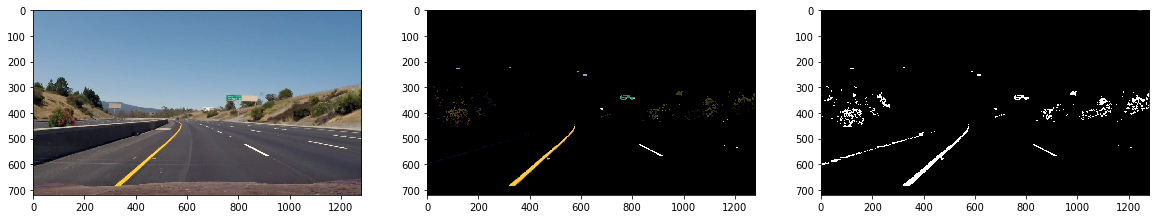

In [4]:
bin  = cv2.inRange(S, 100, 255) #thresholding(L, min=150, max=195)
mask = cv2.cvtColor(bin, cv2.COLOR_GRAY2RGB) #np.dstack([bin,bin, bin])
a_img  = cv2.bitwise_and(image, mask)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax2.imshow(a_img)
ax3.imshow(bin, cmap='gray')

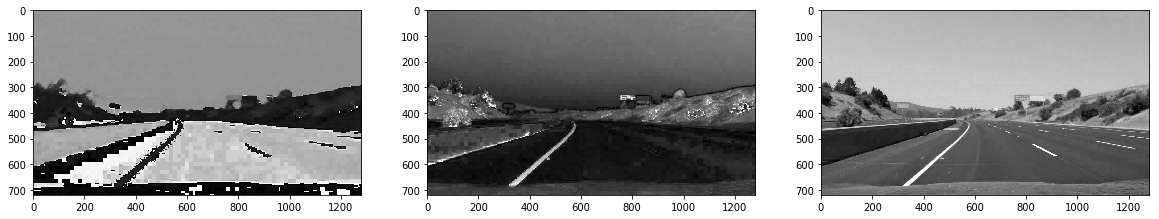

In [5]:
HSV   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(HSV)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(h, cmap='gray')
ax2.imshow(s, cmap='gray')
ax3.imshow(v, cmap='gray')


In [6]:
yuv        = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
img       = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)


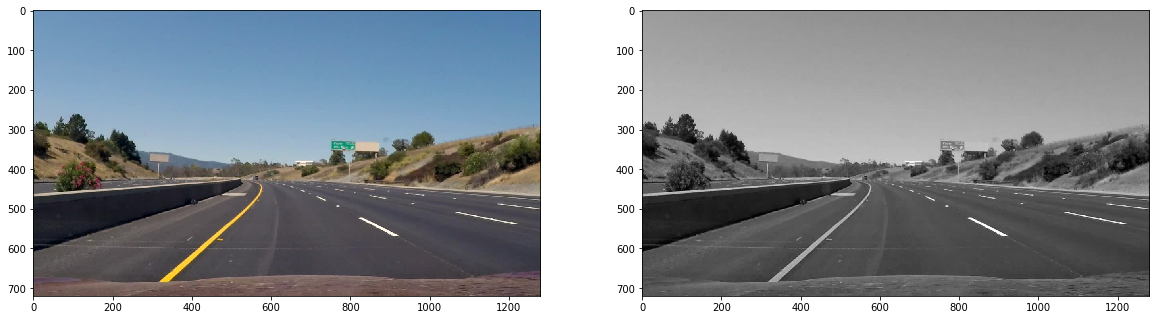

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax2.imshow(yuv[:,:,0], cmap='gray')

179
66


(array([  1.57000000e+02,   3.46000000e+02,   9.43000000e+02,
          3.76336000e+05,   6.24240000e+04,   3.29813000e+05,
          1.44358000e+05,   3.84400000e+03,   1.70400000e+03,
          1.67500000e+03]),
 array([  66. ,   77.3,   88.6,   99.9,  111.2,  122.5,  133.8,  145.1,
         156.4,  167.7,  179. ]),
 <a list of 10 Patch objects>)

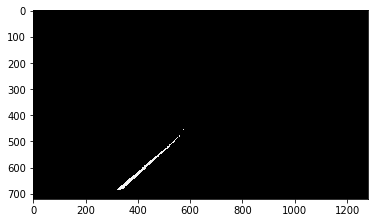

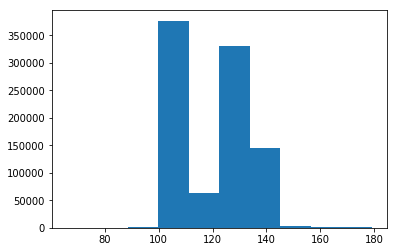

In [8]:
u    = yuv[:,:,1]
u_mask = thresholding(yuv[:,:,1], min=160, max=179)
plt.figure()
plt.imshow(u_mask * u, cmap='gray')
print(u.max())
print(u.min())
plt.figure()
plt.hist(u.flatten())

254
0


(array([  13093.,   51959.,  144287.,  195171.,   50858.,  144161.,
         236134.,   84584.,     467.,     886.]),
 array([   0. ,   25.4,   50.8,   76.2,  101.6,  127. ,  152.4,  177.8,
         203.2,  228.6,  254. ]),
 <a list of 10 Patch objects>)

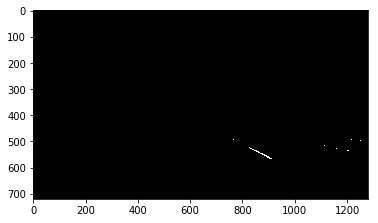

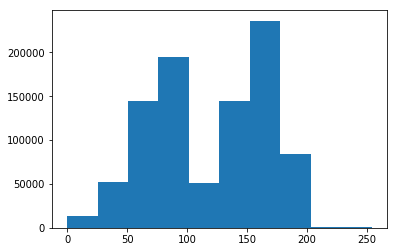

In [9]:
y = yuv[:,:,0]
y_mask = thresholding(y, min=240, max=255)
plt.figure()
plt.imshow(y_mask * y, cmap='gray')
print(y.max())
print(y.min())
plt.figure()
plt.hist(y.flatten())

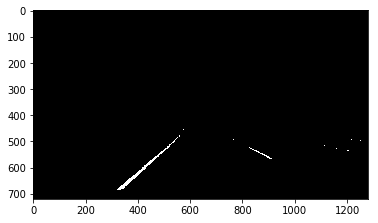

In [10]:
combin = np.zeros_like(S).astype(np.uint8)
combin[(u_mask == 1) | (y_mask==1)]=1
plt.figure()
plt.imshow(combin, cmap='gray')

In [372]:
def process_frame(frame):
    yuv   = cv2.cvtColor(frame, cv2.COLOR_RGB2YUV)
    y,u,v = cv2.split(yuv)
    
    y_mask = thresholding(y, min=240, max=255)
    u_mask = thresholding(yuv[:,:,1], min=160, max=179)
    
    combin = np.zeros_like(y).astype(np.uint8)
    combin[(u_mask == 1) | (y_mask==1)]=1
    
    new_frame =  frame * np.dstack([combin, combin, combin])
    
    part1 = cv2.resize(frame,(0,0),fx=0.25, fy=0.25)
    part2 = cv2.resize(new_frame,(0,0),fx=0.25, fy=0.25)
    
    frame[50:230, 900:1220] = part2
    frame[50:230, 400:720] = part1
    return frame
    

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_frame)
processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [00:25<00:00, 50.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [348]:
def process_frame2(frame):
    HLS   = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS_FULL)
    H,L,S = cv2.split(HLS)
    bin  = thresholding(S, min=90, max=255)
    mask = cv2.cvtColor(bin, cv2.COLOR_GRAY2RGB) #np.dstack([bin,bin, bin])
    return cv2.bitwise_and(frame, mask*255)

video_output1 = 'project_video_output2.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_frame2)
processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [00:23<00:00, 56.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 



In [371]:
def select_white_yellow(image):
    converted = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)
video_output1 = 'project_video_output3.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(select_white_yellow)
processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output3.mp4
[MoviePy] Writing video project_video_output3.mp4


100%|█████████▉| 1260/1261 [00:17<00:00, 73.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output3.mp4 



(0, 255)

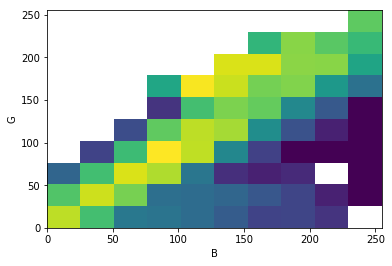

In [368]:
#python
from scipy.stats import lognorm


b = image[:,:,0]
b = b.reshape(b.shape[0]*b.shape[1])
g = image[:,:,1]
g = g.reshape(g.shape[0]*g.shape[1])
r = image[:,:,2]
r = r.reshape(r.shape[0]*r.shape[1])
B = np.append(B,b)
G = np.append(G,g)
R = np.append(R,r)

nbins = 10
plt.hist2d(B, G, bins=nbins,norm=colors.LogNorm())
plt.xlabel('B')
plt.ylabel('G')
plt.xlim([0,255])
plt.ylim([0,255])

In [11]:

def hls_thresh(img, s_thresh, r_thresh):
    # Yellow Line filter
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # White Line filter
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    mask = np.zeros_like(s_channel)
    mask[(s_binary == 1) | (r_binary == 1)] = 1
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def hsv_thresh(img, l_yellow, h_yellow, l_white, h_white):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, l_yellow, h_yellow)
    white = cv2.inRange(hsv, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def luv_thresh(img, l_yellow, h_yellow, l_white, h_white):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    yellow = cv2.inRange(luv, l_yellow, h_yellow)
    white = cv2.inRange(luv, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def lab_thresh(img, l_yellow, h_yellow, l_white, h_white):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    yellow = cv2.inRange(lab, l_yellow, h_yellow)
    white = cv2.inRange(lab, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

In [12]:
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import interact

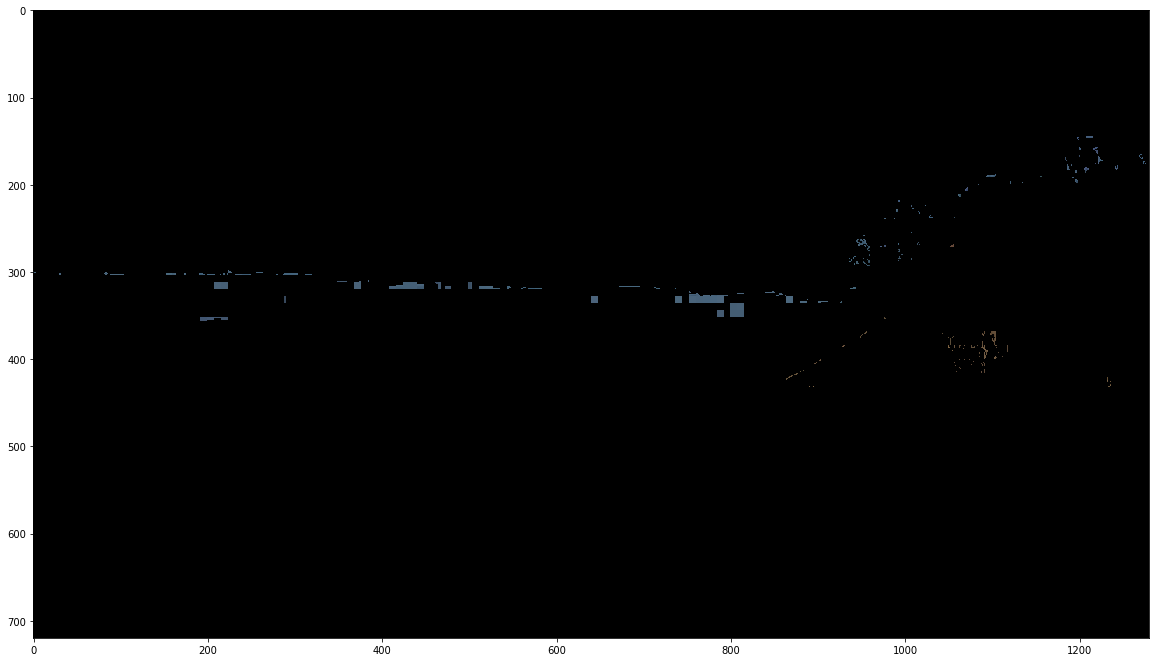

((0, 100, 90), (127, 127, 127), (127, 127, 127), (127, 127, 127))

In [54]:
from ipywidgets import interact

def mask(y_l1, y_l2, y_l3, y_u1, y_u2, y_u3, w_l1, w_l2, w_l3, w_u1, w_u2, w_u3):
    image = plt.imread('./frames/frame-0568.jpg')
    lower_yellow = np.array([y_l1, y_l2, y_l3])
    upper_yellow = np.array([y_u1, y_u2, y_u3])
    lower_white = np.array([w_l1, w_l2, w_l3])
    upper_white = np.array([w_u1, w_u2, w_u3])
    mask, res =  hsv_thresh(image, lower_yellow, upper_yellow, lower_white, upper_white)
    plt.figure(figsize=(20,20))
    plt.imshow(res)
    plt.show()
    return (y_l1, y_l2, y_l3), (y_u1, y_u2, y_u3), (w_l1, w_l2, w_l3), (w_u1, w_u2, w_u3)

v = (0,255,1)

interact(mask, y_l1=v, y_l2=v, y_l3=v, y_u1=v, y_u2=v, y_u3=v, w_l1=v, w_l2=v, w_l3=v, w_u1=v, w_u2=v, w_u3=v)

In [37]:
from thresholding import *

def grad_mask(img):
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 100))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(img, thresh=(30, 100))
    #dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

    grad = np.zeros_like(gradx)
    grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1))] = 1
    return grad

In [38]:
def color_mask(image, lower_yellow, upper_yellow, lower_white, upper_white):
    yellow_mask = cv2.inRange(image, lower_yellow, upper_yellow)
    white_mask  = cv2.inRange(image, lower_white,  upper_white)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    return mask

HSV = lambda image: cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hsv_mask = lambda image: color_mask(HSV(image), np.array([0, 100 ,90]), np.array([22, 220, 255]), np.array([0, 0, 180]), np.array([180, 25, 255]))

In [50]:
LUV = lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
yuv_mask = lambda imsg: color_mask(LUV(imsg), np.array([0, 0 , 0]),	np.array([255,255, 105]), np.array([0, 239, 255]),np.array([255, 255, 255]))


In [51]:
LAB = lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
lab_mask = lambda imsg: color_mask(LAB(imsg), np.array([0, 0 , 80]), np.array([255, 255, 105]),np.array([196, 0, 0]),np.array([255, 255, 255]))


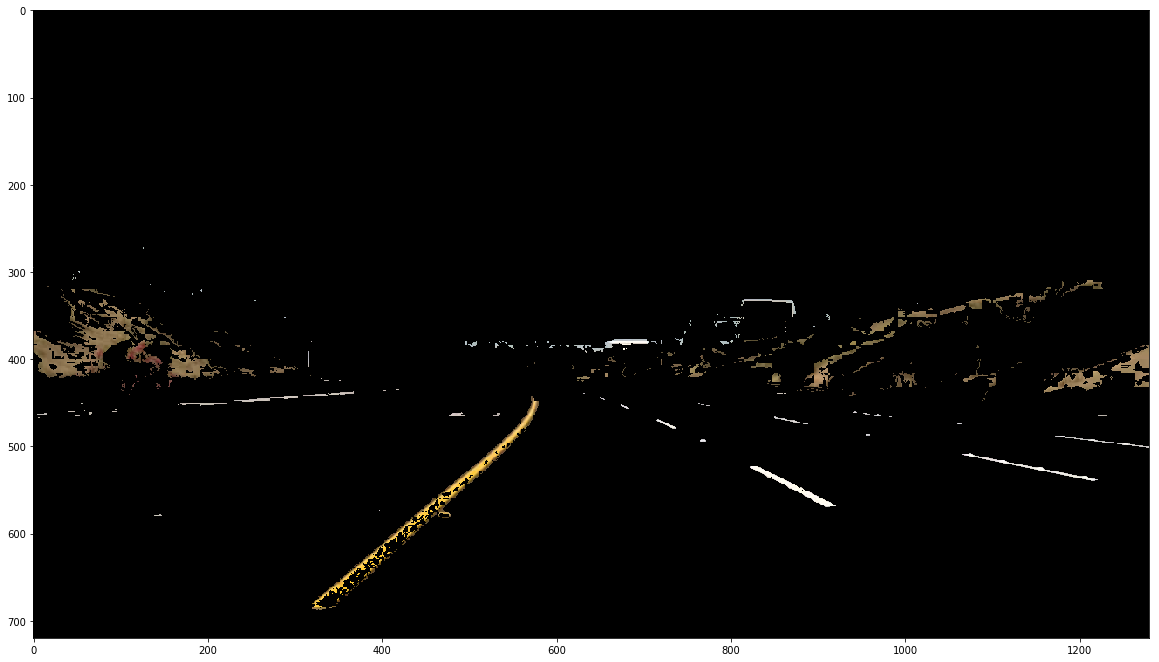

In [53]:
mask = hsv_mask(image)
plt.figure(figsize=(20,20))
plt.imshow(cv2.bitwise_and(image, image, mask=mask))

In [443]:
def process_frame(frame):
    color = cv2.bitwise_or(luv_mask(frame), hsv_mask(frame))
    
    # Combine two methods
    grad = abs_sobel_thresh(frame, 'x', sobel_kernel=3, thresh=(30, 100))
    mask = np.zeros_like(gradx)
    mask[(grad == 1) | (color == 255)] = 1
    
    part1 = cv2.resize(frame,(0,0),fx=0.25, fy=0.25)
    part2 = cv2.resize(cv2.bitwise_and(frame, frame, mask=mask),(0,0),fx=0.25, fy=0.25)
    
    frame[50:230, 900:1220] = part2
    frame[50:230, 400:720] = part1
    return frame
    

video_output1 = 'project_video_output_all.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_frame)
processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_all.mp4
[MoviePy] Writing video project_video_output_all.mp4


100%|█████████▉| 1260/1261 [00:52<00:00, 24.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_all.mp4 



In [ ]:
def process_frame(frame):
    color = cv2.bitwise_or(luv_mask(frame), hsv_mask(frame))
    
    # Combine two methods
    grad = abs_sobel_thresh(frame, 'x', sobel_kernel=3, thresh=(30, 100))
    mask = np.zeros_like(gradx)
    mask[(grad == 1) | (color == 255)] = 1
    
    part1 = cv2.resize(frame,(0,0),fx=0.25, fy=0.25)
    part2 = cv2.resize(cv2.bitwise_and(frame, frame, mask=mask),(0,0),fx=0.25, fy=0.25)
    
    frame[50:230, 900:1220] = part2
    frame[50:230, 400:720] = part1
    return frame
    

video_output1 = 'project_video_output_all.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_frame)
processed_video.write_videofile(video_output1, audio=False)